# Direct Feedback Alignment

Although backpropagation remains the most popular choice to train a neural network, other methods exist. In backpropagation, the error is propagated backwards from the output layer through all hidden layers to the input layer, and the weights defining the layers are changed according to the propagated error.

["Direct Feedback Alignment"](https://arxiv.org/abs/1609.01596), building on work by [Lillicrap et al.](https://www.nature.com/articles/ncomms13276), takes a different approach. Instead of using the weight matrix from the layer downstream of the current layer that needs to be trained, a random (but fixed) matrix is used.

This means for a small network given by:
(Input Layer: x) $\rightarrow W_0 \rightarrow$ (Hidden Layer: h) $\rightarrow W \rightarrow$ (Output Layer: y)

in backpropagation:
* $\Delta W \propto eh^T$
* $\Delta W_0 \propto - W^T ex^T$

where $e$ is the error in the output layer $e = y - \hat{y}$,  and $h=W_0x$ is the output of the hidden layer (prior to the activation function).

Instead, in Direct Feedback Alignment, a random (but fixed) matrix $B$ is used instead of $W$ in the second step and each hidden layer is trained using its own fixed random matrix. This way, the output error is used to directly update the weights of the hidden layers instead of propagating the error backwards.

*Note*: 
The following network is a direct copy of the notebook "neural network from scratch"  in this repository, where the minimal change required to replace backpropagation with Direct Feedback Aligment was done.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#for logistic sigmoid function (a.ka. expit)
from scipy.special import expit

# import of sigmoid and crossentropy
from scipy.special import expit
from sklearn.metrics import log_loss


import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
np.random.seed(1234)
%matplotlib inline
import sys

Using TensorFlow backend.


## Iris Dataset
This example will use the popular "iris" dataset.

The [Iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) was [originally introduced](http://en.wikipedia.org/wiki/Iris_flower_data_set) by Sir Robert Fisher in 1936 as an example for discriminant analysis.
The data focus on how to discriminate between three different types of the [iris flower](http://en.wikipedia.org/wiki/Iris_(plant) ):

* Setosa, 
* Versicolour and
* Virginica

Each row in the dataset contains the following features (measured in cm):

* Sepal Length, 
* Sepal Width, 
* Petal Length and 
* Petal Width.

The labels (true values) are mapped as integers in $[0,1,2]$ for the three different flower types. We will transform this via one-hot encoding to make the computations regarding the loss function easier later.

As this is a popular dataset, it is contained in various machine learning packages.
Here we use the data from the [SciKit-Learn](https://scikit-learn.org/stable/) machine learning suite.

Note that the dataset is quite small with only 150 observations. However, it has the benefit that the subsequent processing and network training is very fast, and it serves us well to illustrate the principles.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
print('number of samples: {}'.format(len(iris.data)))

number of samples: 150


In [ ]:

# access the data and split into helper arrays.
x1 = iris.data
y1 = iris.target

# The samples are ordered by target class # in the original dataset. 
# As a first step, we shuffle the order before splitting the data into
# training and test data
perm = np.random.permutation(x1.shape[0])
y2 = y1[perm]
x2 = x1[perm,:]

# now we take 90% of the data for trainig and 10% for testing
frac_train = 0.9
train_index = int(round(len(iris.data)*frac_train))
X_train = x2[0:train_index]
X_test  = x2[train_index+1 :]

y_train = y2[0:train_index]
y_test  = y2[train_index+1 :]

# convert the class number into one-hot encoding.
# e.g. target class 2 -> [0,0,1]
n_classes = 3
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

## Forward and DFA Pass

This is the core of the neural network training. During the forward
pass we use the current settings of the weights and calculate the network response. During the backward pass in backpropagation, we compare the output to the desired output and calculate the change of the weights.

Note that we train the network such that during each weight update or learning step we present a batch of input signals to the network instead of just one.
For example, if we have four input variables, we do not just present $(x_1,x_2,x_3,x_4)$ to the network to learn from this pattern, but each of $x_1,x_2,x_3,$ and $x_4$ is a vector itself that containts $n$ training samples.

### Forward Pass
We need to calculate the response of the network.
In our small network, we only need to compute the path from the input to the hidden layer and from the hidden to the output layer.

* Input to hidden layer: \
$a_1 = W_1 x + b_1$, $h_1 = f(a_1)$ where $f(.)$ is the activation function for the hidden layer. We will use the tanh(x) function here.

* Hidden to output layer: \
$a_2 = W_2 h_1 +  b_2$, $\hat{y} = f_y(a_2)$ where $f_y(.)$ is the activation function for the output layer. We will use the sigmoid function here because it is more convenient in the backward pass.
The sigmoid function is given by: $ \sigma(x) = \frac{1}{1+e^{-x}}$

### DFA Pass

The random matrix $B_1$ is used to update the weights in the hidden layer.
This is the only change to switch from backpropagation to Direct Feedback Alignment.

In [ ]:
#
# Forward pass: calculate network response
# N.B. need to append as many components to the bias b1 and b2
#      as we have elements in each training batch using np.tile 
def forward_pass(W1, W2, b1, b2, x):
  #input to hidden layer
  a1 = np.matmul(W1,x) + np.tile(b1, x.shape[1])  
  h1 = np.tanh(a1)

  #hidden to output layer
  a2 = np.matmul(W2, h1) + np.tile(b2, x.shape[1])

  #output layer has sigmoid activation
  y_hat = expit(a2)

  return a1, h1, a2, y_hat

#
# DFA pass: calculate changes to weights
# using random matrix B1
#
def backward_pass_DFA(e, h1, B1, a1, x):
  dW2 = -np.matmul(e, np.transpose(h1))            
  da1 = np.matmul(B1, e)*(1-np.tanh(a1)**2)   # <--- only change w.r.t.
                                              #      backpropagation

  dW1 = -np.matmul(da1, np.transpose(x))                  

  # change in bias b1 and b2:
  db2 = -np.sum(e, axis=1)
  db1 = -np.sum(da1, axis=1)

  return dW1, dW2, db1[:, np.newaxis], db2[:,np.newaxis]



## Network training

In [ ]:
#
# Network parameters
#
n_input  = 4
n_hidden = 100
n_output = n_classes

batch_size = 32
learn_rate = 1e-4
n_epochs   = 100

# we need to change the shape of the data from a long array 
# with four variables per observation to an array with the four
# input variables, each with the observations (per variable)
# and accordingly for the output for the calculations of the weights.
x = np.transpose(X_train)
y = np.transpose(y_train)

#
# initialize network weights
#
W1 = np.random.randn(n_hidden, n_input)
W2 = np.random.randn(n_output, n_hidden)

b1 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(n_output, 1)


# DFA matrix: random but fixed matrix
# the rest of this function is exactly the same as in the case of 
# training with backpropagation
B1 = np.random.randn(n_hidden, n_output)

dataset_size = x.shape[1]
n_batches = dataset_size//batch_size
print('Dataset size: {}, batch_size: {}, number of batches {}'.format(dataset_size, batch_size, n_batches))

# save the total error for each epoch, summed over all batches
train_error_epoch = []



for i in range(n_epochs):
  #shuffle training data
  perm = np.random.permutation(x.shape[1])
  x = x[:, perm]
  y = y[:, perm]

  # value of loss function and training error
  loss = 0.0
  train_error = 0.0

  #
  # loop over batches
  #
  for j in range(n_batches):
    train_data = x[:, j*batch_size:(j+1)*batch_size]
    targets    = y[:, j*batch_size:(j+1)*batch_size]
    #
    # forward pass
    #
    a1, h1, a2, y_hat = forward_pass(W1=W1, W2=W2, b1=b1, b2=b2, x=train_data)

    # metrics
    error = y_hat - targets

    # due to one-hot encoding, each prediction and true label is an array
    # recover the class number via np.argmax
    preds = np.argmax(y_hat, axis=0) 
    truth = np.argmax(targets, axis=0)

    # error is the difference between prediction and true, summed over
    # all elements in the batch
    train_error += np.sum(preds!=truth)

    # cross entropy loss
    loss_on_batch = log_loss(targets, y_hat)

    #
    # calculate change of weights - backward pass
    #
    dW1, dW2, db1, db2 = backward_pass_DFA(e=error, h1=h1, B1=B1, a1=a1, x=train_data)

    #weight update
    W1 += learn_rate * dW1
    W2 += learn_rate * dW2
    b1 += learn_rate * db1
    b2 += learn_rate * db2
    loss += loss_on_batch

  #update errors per epoch
  training_error = 100.*train_error/x.shape[1]
  train_error_epoch.append(training_error)

Dataset size: 135, batch_size: 32, number of batches 4


Visualize the training error per epoch

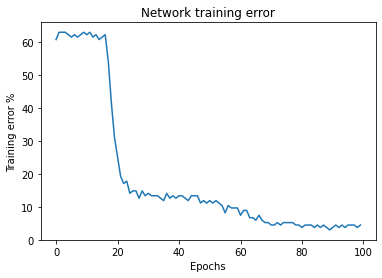

In [ ]:
x = range(0,n_epochs)
plt.plot(x, train_error_epoch, label='training error')
plt.title('Network training error')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
#plt.legend(loc='best')
plt.show()

Use the independent test sample to test the network performance.
Note that the Iris dataset is very small, and we only use it here because the calculations are very fast and the data are already available within the libraries we use.
Feel free to experiment with different samples.

In [ ]:
test_samples = np.transpose(X_test)
test_targets = np.transpose(y_test)
    
y_hats = forward_pass(W1, W2, b1, b2, test_samples)[-1]
preds = np.argmax(y_hats, axis=0) 
truth = np.argmax(test_targets, axis=0)
test_error = 1.*np.sum(preds!=truth)/preds.shape[0]

print('Test error:', test_error, '%')

Test error: 0.0 %
